In this notebook, we are going to explore anomalies in rpm values for pc1 and pc2 seperately.

In [1]:
import pandas as pd

# Python standard library imports
import time

# Third-party imports for database connection and data manipulation
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Database connection parameters
dbname = 'train_weather'
user = 'narmina'
password = 'narmina7877'
host = 'localhost'  # localhost or the server address
port = '5433'  # default PostgreSQL port is 5432

# Establish a connection to the database
connection_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
engine = create_engine(connection_str)

We have a rule that the maximum acceptable temperatures are for the: air: 65°C, water: 100°C, oil: 115°C. Above those thresholds the engines are stopped automatically to avoid damage. When engine stops, rpm value should be 0. Now we are going to check if this condition meets.

In [3]:
# Define the query with placeholders for parameters
query1 = f"""
SELECT *, 'rmp' AS outlier_type
FROM vehicle_data_enriched where 
("RS_E_InAirTemp_PC1" > 65) or 
("RS_E_WatTemp_PC1" > 100) or 
("RS_T_OilTemp_PC1" > 115);
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df1 = pd.read_sql_query(query1, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.23310112953186035 seconds to run.


In [4]:
print(df1)

     mapped_veh_id       timestamps_UTC        lat       lon  \
0            150.0  2023-08-25 07:24:15  51.015536  3.775840   
1            150.0  2023-08-25 06:40:09  51.032688  3.738170   
2            174.0  2023-08-04 13:04:21  50.419657  4.534719   
3            119.0  2023-08-14 19:48:19  51.013374  3.780435   
4            149.0  2023-08-08 20:29:30  51.035646  3.710804   
..             ...                  ...        ...       ...   
836          140.0  2023-09-06 21:33:36  50.400574  4.459039   
837          117.0  2023-09-07 12:08:20  51.015642  3.775553   
838          181.0  2023-09-07 19:49:24  50.742379  3.602668   
839          181.0  2023-09-07 20:00:21  50.742386  3.602660   
840          117.0  2023-09-08 09:29:38  51.014937  3.777092   

     RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0                  77.0                32.0                0.0   
1                  78.0                33.0                0.0   
2                  66.0          

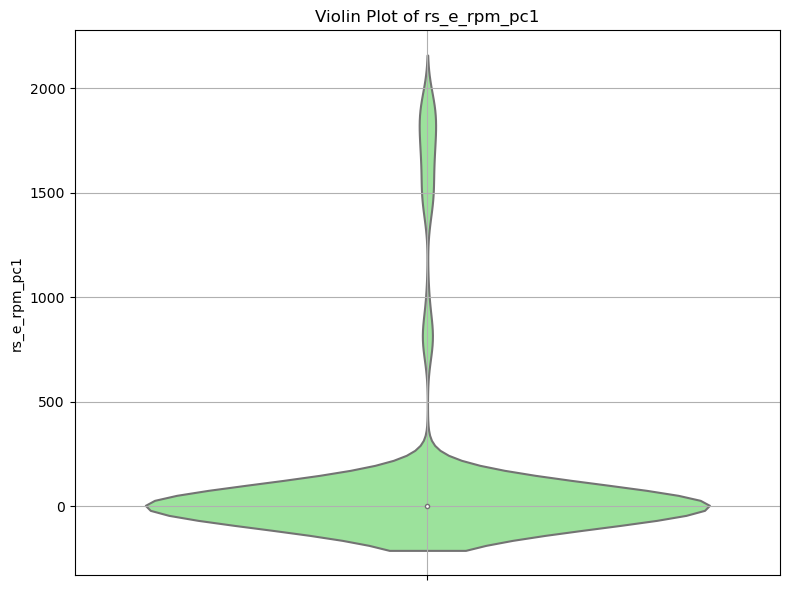

In [5]:
# Violin plot for rs_e_rpm_pc1 values
plt.figure(figsize=(8, 6))
sns.violinplot(y=df1['rs_e_rpm_pc1'], color='lightgreen')

plt.ylabel('rs_e_rpm_pc1')
plt.title('Violin Plot of rs_e_rpm_pc1')
plt.grid(True)
plt.tight_layout()
plt.show()


Now, we can see that not all values of rpm is zero, so there are anomalies. Now, let's check if these anomalies have some patterns followed.

In [6]:
non_zero_indices = df1.index[df1['rs_e_rpm_pc1'] != 0].tolist()

# Calculate differences between consecutive non-zero indices
index_differences = [j - i for i, j in zip(non_zero_indices[:-1], non_zero_indices[1:])]

# Check if there is any pattern in index differences
if len(set(index_differences)) == 1:
    print(f"There is a pattern in the index differences: {index_differences[0]}")
else:
    print("No specific pattern found in index differences.")

No specific pattern found in index differences.


There is no specific patterns followed. We can continue to see how many anomly cases we have for rpm values

In [7]:
# Define the query with placeholders for parameters
query2 = f"""
SELECT *, 'rmp' AS outlier_type
FROM vehicle_data_enriched where rs_e_rpm_pc1<>0 and 
(("RS_E_InAirTemp_PC1" > 65) or 
("RS_E_WatTemp_PC1" > 100) or 
("RS_T_OilTemp_PC1" > 115));
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df2 = pd.read_sql_query(query2, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.06429481506347656 seconds to run.


In [8]:
print(df2)

    mapped_veh_id       timestamps_UTC        lat       lon  \
0           128.0  2023-08-15 11:59:28  51.181219  5.061351   
1           128.0  2023-08-16 10:43:41  51.015487  5.348506   
2           164.0  2023-08-20 15:10:29  51.172743  4.916521   
3           151.0  2023-08-23 07:10:45  51.015628  3.775230   
4           128.0  2023-08-10 13:41:04  51.050257  5.236593   
..            ...                  ...        ...       ...   
63          181.0  2023-06-04 14:29:26  50.953031  3.781030   
64          136.0  2023-06-05 16:16:12  51.168564  4.962454   
65          160.0  2023-05-20 16:31:00  50.919401  3.791549   
66          123.0  2023-05-22 15:24:05  51.133095  5.239574   
67          190.0  2023-05-19 13:39:28  51.238252  5.456693   

    RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0                 47.0                46.0              327.0   
1                 43.0                45.0               72.0   
2                 66.0                46.0      

In [9]:
df2.to_csv('/Users/narmina/Downloads/file.csv', index=False)

We can see that 3212 rpm values are shown incorrectly for pc1. So, from here we can say that the sensors show wrong values for rpm or engines are not shutted down. 

In order to find when these specific cases happen most, we can group those abnormal cases first by weeks of the day.

In [10]:
query3 = f"""
SELECT 
    TO_CHAR("timestamps_UTC"::timestamp, 'Day') AS day_of_week,
    COUNT("rs_e_rpm_pc1") AS rpm_count
FROM 
    vehicle_data_enriched 
WHERE 
    "rs_e_rpm_pc1" <> 0 AND 
    (
        ("RS_E_InAirTemp_PC1" > 65) or 
        ("RS_E_WatTemp_PC1" > 100) or 
        ("RS_T_OilTemp_PC1" > 115)
    )
GROUP BY 
    day_of_week
ORDER BY rpm_count DESC
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df3 = pd.read_sql_query(query3, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.06337904930114746 seconds to run.


In [11]:
print(df3)

  day_of_week  rpm_count
0   Sunday            14
1   Monday            11
2   Saturday          10
3   Thursday          10
4   Tuesday            9
5   Wednesday          8
6   Friday             6


We can observe that on Monday and Sunday anomaly cases for rpm values are the highest.

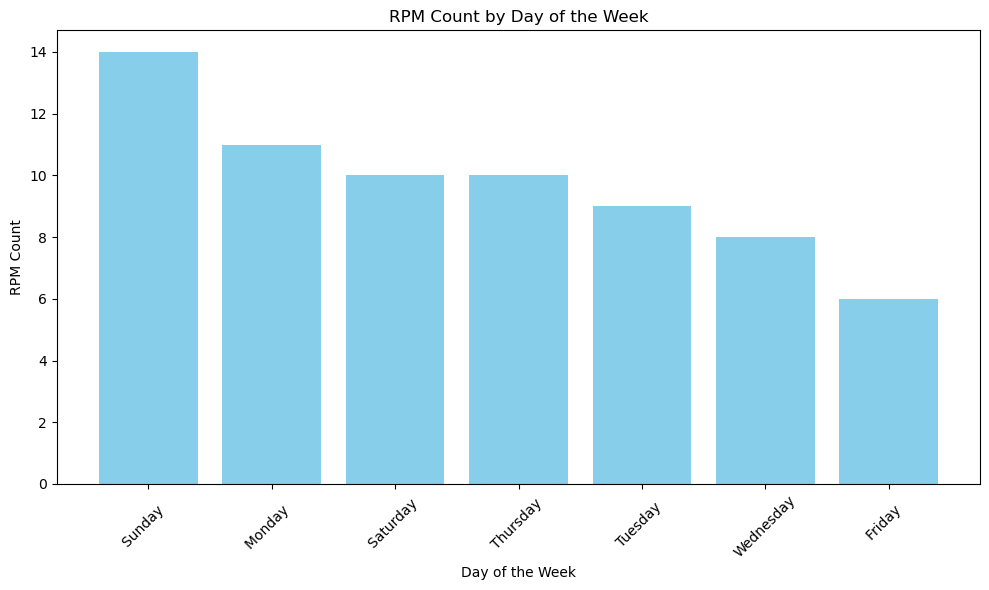

In [12]:
# Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size

# Plotting a bar chart
plt.bar(df3['day_of_week'], df3['rpm_count'], color='skyblue')

# Adding labels and title
plt.xlabel('Day of the Week')
plt.ylabel('RPM Count')
plt.title('RPM Count by Day of the Week')

# Rotating x-axis labels for better visibility if necessary
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

Now, let's see which months have most number of anomalies

In [13]:
query4 = f"""
SELECT 
    EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) AS month_number,
    CASE EXTRACT(MONTH FROM "timestamps_UTC"::timestamp)
        WHEN 1 THEN 'January'
        WHEN 2 THEN 'February'
        WHEN 3 THEN 'March'
        WHEN 4 THEN 'April'
        WHEN 5 THEN 'May'
        WHEN 6 THEN 'June'
        WHEN 7 THEN 'July'
        WHEN 8 THEN 'August'
        WHEN 9 THEN 'September'
        WHEN 10 THEN 'October'
        WHEN 11 THEN 'November'
        WHEN 12 THEN 'December'
    END AS month_name,
    COUNT("rs_e_rpm_pc1") AS rpm_count
FROM 
    vehicle_data_enriched 
WHERE 
    "rs_e_rpm_pc1" <> 0 AND 
    (
        ("RS_E_InAirTemp_PC1" > 65) or 
        ("RS_E_WatTemp_PC1" > 100) or 
        ("RS_T_OilTemp_PC1" > 115)
    )
GROUP BY 
    month_number, month_name
ORDER BY 
    rpm_count DESC;
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df4 = pd.read_sql_query(query4, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.05147886276245117 seconds to run.


In [14]:
print(df4)

   month_number month_name  rpm_count
0           6.0       June         27
1           5.0        May         20
2           8.0     August         20
3           9.0  September          1


We can clearly see that anomaly cases happen most in summer months, especially in June and May

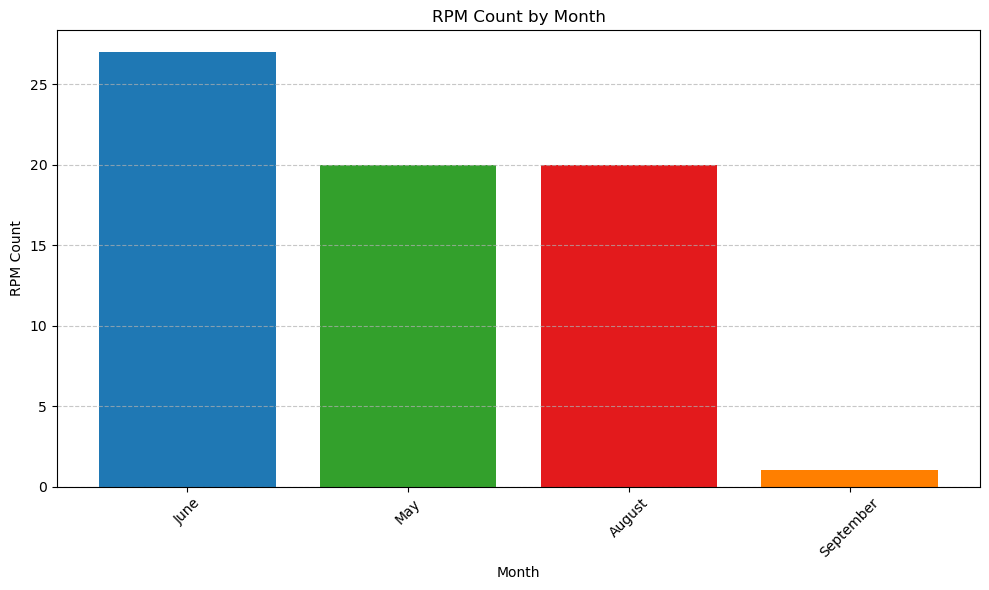

In [15]:
# Define a color palette with more similar tones for the bars
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#ffff99']

# Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size

# Plotting a bar chart with custom colors
plt.bar(df4['month_name'], df4['rpm_count'], color=colors)

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('RPM Count')
plt.title('RPM Count by Month')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

Now, let's make sure that the the pick season for anamly cases is Summer.

In [16]:
query5 = f"""
SELECT 
    CASE 
        WHEN EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) BETWEEN 3 AND 5 THEN 'Spring'
        WHEN EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) BETWEEN 6 AND 8 THEN 'Summer'
        WHEN EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) BETWEEN 9 AND 11 THEN 'Autumn'
        ELSE 'Winter'
    END AS season,
    COUNT("rs_e_rpm_pc1") AS rpm_count
FROM 
    vehicle_data_enriched 
WHERE 
    "rs_e_rpm_pc1" <> 0 AND 
    (
        ("RS_E_InAirTemp_PC1" > 65) or 
        ("RS_E_WatTemp_PC1" > 100) or 
        ("RS_T_OilTemp_PC1" > 115)
    )
GROUP BY 
    season
ORDER BY rpm_count DESC;
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df5 = pd.read_sql_query(query5, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.05304527282714844 seconds to run.


In [17]:
print(df5)

   season  rpm_count
0  Summer         47
1  Spring         20
2  Autumn          1


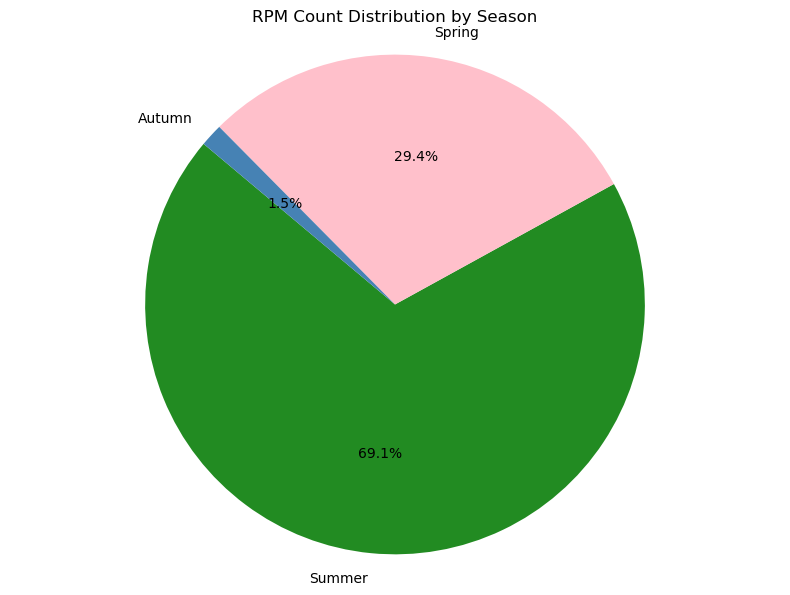

In [18]:
# Define colors associated with each season for the pie chart
colors = ['#228B22', '#FFC0CB', '#4682B4', '#FFA500']  # Green, Pink, Blue, Orange

# Plotting the data
plt.figure(figsize=(8, 6))  # Set the figure size

# Create a pie chart with season-wise colors
plt.pie(df5['rpm_count'], labels=df5['season'], colors=colors, autopct='%1.1f%%', startangle=140)

# Adding title
plt.title('RPM Count Distribution by Season')

# Show plot
plt.tight_layout()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


Now we are sure that in Summer there are the most anomalies with rpm values for pc1.

Let's check the same for pc2. We start with checking if any values of rpm is different than 0 when temperature values exceed the thresholds.

In [19]:
# Define the query with placeholders for parameters
query6 = f"""
SELECT *, 'rmp' AS outlier_type
FROM vehicle_data_enriched where         
("RS_E_InAirTemp_PC2" > 65) or 
("RS_E_WatTemp_PC2" > 100) or 
("RS_T_OilTemp_PC2" > 115);
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df6 = pd.read_sql_query(query6, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.08037781715393066 seconds to run.


In [20]:
print(df6)

      mapped_veh_id       timestamps_UTC        lat       lon  \
0             170.0  2023-08-02 06:40:54  51.040250  3.693570   
1             166.0  2023-08-01 21:51:54  51.013072  3.780722   
2             112.0  2023-08-09 16:32:27  50.851310  3.601335   
3             143.0  2023-08-10 10:35:41  51.023376  3.758922   
4             122.0  2023-08-10 11:16:35  51.040146  3.692775   
...             ...                  ...        ...       ...   
1022          128.0  2023-09-06 16:13:13  51.172308  4.921356   
1023          142.0  2023-09-06 22:53:26  51.189488  5.108764   
1024          117.0  2023-09-07 12:08:20  51.015642  3.775553   
1025          117.0  2023-09-08 09:29:38  51.014937  3.777092   
1026          150.0  2023-09-07 22:06:33  51.015695  3.775302   

      RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
0                   62.0                68.0                3.0   
1                   53.0                70.0                6.0   
2                 

We can clearly see that in pc2 there are also anomalies in rpm values. Now let's check if there is any specific pattern follows these anomaly cases.

In [21]:
non_zero_indices = df6.index[df6['rs_e_rpm_pc2'] != 0].tolist()

# Calculate differences between consecutive non-zero indices
index_differences = [j - i for i, j in zip(non_zero_indices[:-1], non_zero_indices[1:])]

# Check if there is any pattern in index differences
if len(set(index_differences)) == 1:
    print(f"There is a pattern in the index differences: {index_differences[0]}")
else:
    print("No specific pattern found in index differences.")

No specific pattern found in index differences.


We found no specific patterns, so we can continue with counting anomaly cases for pc2.

In [22]:
# Define the query with placeholders for parameters
query7 = f"""
SELECT *, 'rmp' AS outlier_type
FROM vehicle_data_enriched where "rs_e_rpm_pc2"<>0 and 
(        
        ("RS_E_InAirTemp_PC2" > 65) or 
        ("RS_E_WatTemp_PC2" > 100) or 
        ("RS_T_OilTemp_PC2" > 115)
);
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df7 = pd.read_sql_query(query7, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.06069779396057129 seconds to run.


In [23]:
print(df7)

    mapped_veh_id       timestamps_UTC        lat       lon  \
0           114.0  2023-06-20 16:25:10  51.033847  5.328631   
1           170.0  2023-06-14 17:01:25  51.074541  3.819753   
2           114.0  2023-06-14 18:14:56  51.162152  5.178867   
3           114.0  2023-06-15 16:10:46  51.169441  4.952769   
4           114.0  2023-06-14 18:31:24  51.041773  5.257927   
5           114.0  2023-06-13 17:19:13  50.995183  5.348533   
6           103.0  2023-06-16 10:51:41  50.505953  4.235119   
7           197.0  2023-06-12 15:15:23  50.493232  4.264886   
8           114.0  2023-06-15 07:38:38  51.213183  5.355031   
9           114.0  2023-06-20 12:31:32  51.042129  5.257052   
10          114.0  2023-06-15 08:51:49  51.147250  4.525949   
11          114.0  2023-06-16 06:44:50  51.205252  5.248726   
12          114.0  2023-06-15 16:11:41  51.171663  4.928425   
13          114.0  2023-06-15 19:37:41  51.213802  5.372432   
14          185.0  2023-06-09 09:45:24  50.960953  5.34

In [24]:
df7.to_csv('/Users/narmina/Downloads/file.csv', index=False)

We can see that there are 3000 anomaly cases

Now let's see the anmolies according to the days of week, months, and seasons.

In [25]:
query8 = f"""
SELECT 
    TO_CHAR("timestamps_UTC"::timestamp, 'Day') AS day_of_week,
    COUNT("rs_e_rpm_pc2") AS rpm_count
FROM 
    vehicle_data_enriched 
WHERE 
    "rs_e_rpm_pc2" <> 0 AND 
    (
        ("RS_E_InAirTemp_PC2" > 65) or 
        ("RS_E_WatTemp_PC2" > 100) or 
        ("RS_T_OilTemp_PC2" > 115)
    )
GROUP BY 
    day_of_week
ORDER BY rpm_count DESC
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df8 = pd.read_sql_query(query8, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.06159615516662598 seconds to run.


In [26]:
print(df8)

  day_of_week  rpm_count
0   Wednesday         11
1   Saturday          11
2   Friday            10
3   Thursday           9
4   Monday             8
5   Tuesday            8
6   Sunday             2


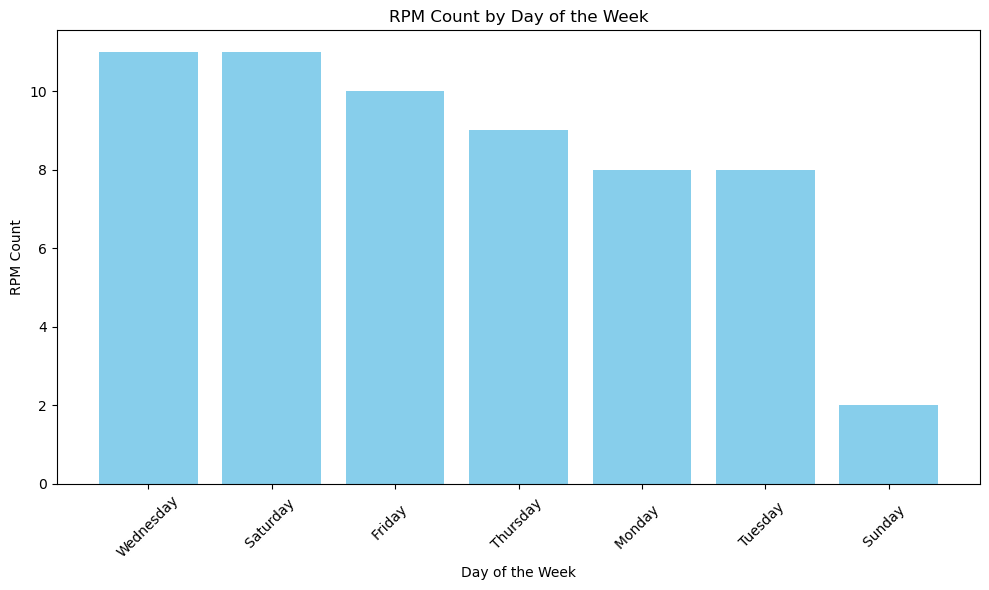

In [27]:
# Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size

# Plotting a bar chart
plt.bar(df8['day_of_week'], df8['rpm_count'], color='skyblue')

# Adding labels and title
plt.xlabel('Day of the Week')
plt.ylabel('RPM Count')
plt.title('RPM Count by Day of the Week')

# Rotating x-axis labels for better visibility if necessary
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

there are more anomalies in rpm values for pc2 on Wednesday

In [28]:
query9 = f"""
SELECT 
    EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) AS month_number,
    CASE EXTRACT(MONTH FROM "timestamps_UTC"::timestamp)
        WHEN 1 THEN 'January'
        WHEN 2 THEN 'February'
        WHEN 3 THEN 'March'
        WHEN 4 THEN 'April'
        WHEN 5 THEN 'May'
        WHEN 6 THEN 'June'
        WHEN 7 THEN 'July'
        WHEN 8 THEN 'August'
        WHEN 9 THEN 'September'
        WHEN 10 THEN 'October'
        WHEN 11 THEN 'November'
        WHEN 12 THEN 'December'
    END AS month_name,
    COUNT("rs_e_rpm_pc2") AS rpm_count
FROM 
    vehicle_data_enriched 
WHERE 
    "rs_e_rpm_pc2" <> 0 AND 
    (
        ("RS_E_InAirTemp_PC2" > 65) or 
        ("RS_E_WatTemp_PC2" > 100) or 
        ("RS_T_OilTemp_PC2" > 115)
    )
GROUP BY 
    month_number, month_name
ORDER BY 
    rpm_count DESC;
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df9 = pd.read_sql_query(query9, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.05001187324523926 seconds to run.


In [29]:
print(df9)

   month_number month_name  rpm_count
0           6.0       June         37
1           5.0        May         20
2           9.0  September          2


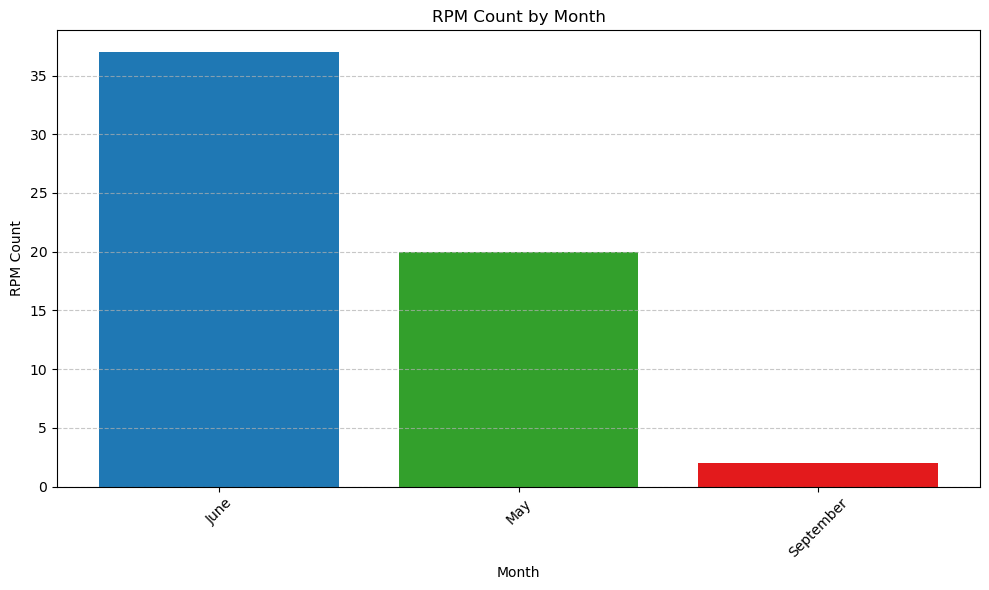

In [30]:
# Define a color palette with more similar tones for the bars
colors = ['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a', '#b15928', '#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6', '#ffff99']

# Plotting the data
plt.figure(figsize=(10, 6))  # Set the figure size

# Plotting a bar chart with custom colors
plt.bar(df9['month_name'], df9['rpm_count'], color=colors)

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('RPM Count')
plt.title('RPM Count by Month')

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

as in pc1, June and May are the months having the most number of anomalies for rpm values of pc2

In [31]:
query10 = f"""
SELECT 
    CASE 
        WHEN EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) BETWEEN 3 AND 5 THEN 'Spring'
        WHEN EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) BETWEEN 6 AND 8 THEN 'Summer'
        WHEN EXTRACT(MONTH FROM "timestamps_UTC"::timestamp) BETWEEN 9 AND 11 THEN 'Autumn'
        ELSE 'Winter'
    END AS season,
    COUNT("rs_e_rpm_pc2") AS rpm_count
FROM 
    vehicle_data_enriched 
WHERE 
    "rs_e_rpm_pc2" <> 0 AND 
    (
        ("RS_E_InAirTemp_PC2" > 65) or 
        ("RS_E_WatTemp_PC2" > 100) or 
        ("RS_T_OilTemp_PC2" > 115)
    )
GROUP BY 
    season
ORDER BY rpm_count DESC;
"""

# Start timing
start_time = time.time()

# Execute the query and fetch the data into a DataFrame
df10 = pd.read_sql_query(query10, engine)

# End timing
end_time = time.time()
print(f"Query took {end_time - start_time} seconds to run.")
# Close the database connection
engine.dispose()

Query took 0.05680704116821289 seconds to run.


In [32]:
print(df10)

   season  rpm_count
0  Summer         37
1  Spring         20
2  Autumn          2


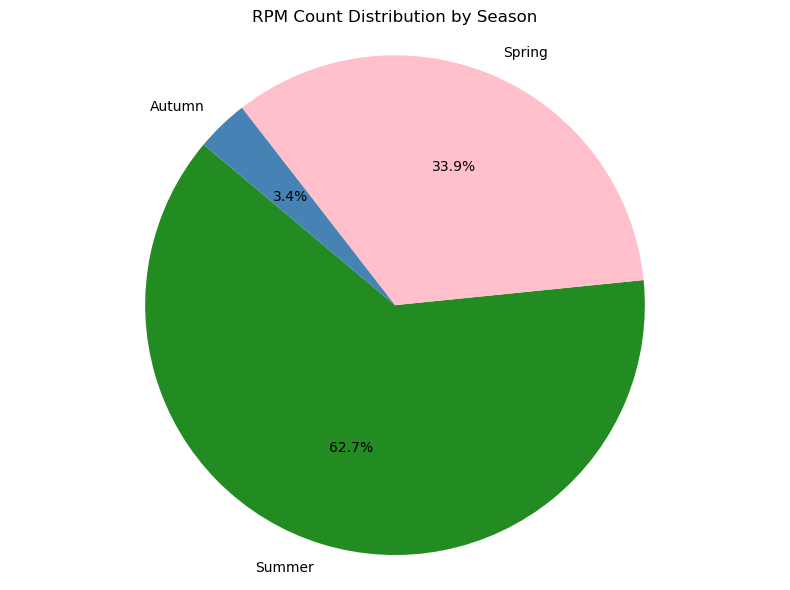

In [33]:
# Define colors associated with each season for the pie chart
colors = ['#228B22', '#FFC0CB', '#4682B4', '#FFA500']  # Green, Pink, Blue, Orange

# Plotting the data
plt.figure(figsize=(8, 6))  # Set the figure size

# Create a pie chart with season-wise colors
plt.pie(df10['rpm_count'], labels=df10['season'], colors=colors, autopct='%1.1f%%', startangle=140)

# Adding title
plt.title('RPM Count Distribution by Season')

# Show plot
plt.tight_layout()
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


also, like in pc1, pc2 have also the most problems woth rpm values in Summer and Spring

In conclusion, we can say that both for pc1 and pc2, there are anomlies around 3000 in rpm values and their reason can be because of the sensor, or maybe the engine was not shutted down. When it comes to when these cases happen most, it is in Summer and Spring